## Imports

In [73]:
# Standard Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Additional Imports
import os, json, math, time
import tmdbsimple as tmdb
from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings(action='ignore')

from sqlalchemy import text
import pymysql
pymysql.install_as_MySQLdb()
import scipy.stats as stats
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists

In [4]:
FOLDER = 'Data/'
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['final_tmdb_data_2006.csv.gz',
 'final_akas.csv.gz',
 'tmdb_api_results_2010.json',
 'final_tmdb_data_2014.csv.gz',
 'tmdb_api_results_2006.json',
 'final_ratings_df.csv.gz',
 'final_tmdb_data_2008.csv.gz',
 'final_tmdb_data_2016.csv.gz',
 'final_ratings.csv.gz',
 'final_tmdb_data_2004.csv.gz',
 'tmdb_api_results_2007.json',
 'final_akas_df.csv.gz',
 'tmdb_api_results_2011.json',
 'tmdb_api_results_2016.json',
 'tmdb_api_results_2000.json',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2012.csv.gz',
 'tmdb_api_results_2001.json',
 'final_tmdb_data_2010.csv.gz',
 'final_tmdb_data_2002.csv.gz',
 'title_basics.csv.gz',
 'tmdb_api_results_2017.json',
 'final_basics_df.csv.gz',
 'tmdb_api_results_2018.json',
 'tmdb_api_results_2002.json',
 'final_tmdb_data_2007.csv.gz',
 'tmdb_api_results_2014.json',
 'final_tmdb_data_2015.csv.gz',
 'tmdb_api_results_2015.json',
 'tmdb_api_results_2003.json',
 'final_tmdb_data_2017.csv.gz',
 'final_tmdb_data_2009.csv.gz',
 'final_tmdb_data_2005.csv.gz'

In [5]:
import json
with open('/Users/brianschreffler/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()

tmdb.API_KEY =  login['api-key']

## Functions

In [6]:
def get_movie_with_rating(movie_id):
    # Get the movie object for the current id
    movie = tmdb.Movies(movie_id)
    # save the .info .releases dictionaries
    info = movie.info()
    
    releases = movie.releases()
    # Loop through countries in releases
    for c in releases['countries']:
        #if the country abbreviation==US
        if c['iso_3166_1']=='US':
            # save a 'certification' key in info with the certification
            info['certification'] = c['certification']
            
    return info

def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

## Load and Prepare data for Api Calls

In [7]:
basics_df = pd.read_csv('Data/title_basics.csv.gz')
display(basics_df.head())
display(basics_df.info())

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9768338 entries, 0 to 9768337
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 670.7+ MB


None

In [8]:
basics_df = basics_df.replace({'\\N': np.nan})
basics_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,NaN,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,NaN,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,NaN,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,NaN,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,NaN,1,"Comedy,Short"


In [9]:
rt_drop = basics_df.dropna(subset=['runtimeMinutes'], inplace = True)

In [10]:
gn_drop = basics_df.dropna(subset=['genres'], inplace = True)

In [11]:
movie_type = basics_df['titleType']=='movie'
basics_df = basics_df.loc[movie_type,:]
basics_df['titleType'].value_counts(dropna = False)
basics_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,NaN,45,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,NaN,100,"Documentary,News,Sport"
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,NaN,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,NaN,90,Drama
672,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0,1908,NaN,120,"Adventure,Fantasy"


In [12]:
basics_df['startYear'] = basics_df['startYear'].astype(float)

In [13]:
date_range = (basics_df['startYear']>=2002)&(basics_df['startYear']<2022)
basics_df = basics_df.loc[date_range,:]
basics_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
13082,tt0013274,movie,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,0,2021.0,NaN,94,Documentary
61116,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
67669,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
86801,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
93938,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama


In [14]:
# Exclude movies that are included in the documentary category.
is_documentary = basics_df['genres'].str.contains('Documentary',case=False)
basics_df = basics_df[~is_documentary]
basics_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
61116,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
67669,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
86801,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
93938,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama
98043,tt0100275,movie,The Wandering Soap Opera,La Telenovela Errante,0,2017.0,NaN,80,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...,...,...,...
9768011,tt9916170,movie,The Rehearsal,O Ensaio,0,2019.0,NaN,51,Drama
9768020,tt9916190,movie,Safeguard,Safeguard,0,2020.0,NaN,95,"Action,Adventure,Thriller"
9768059,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,0,2020.0,NaN,84,Thriller
9768104,tt9916362,movie,Coven,Akelarre,0,2020.0,NaN,92,"Drama,History"


In [15]:
akas_df = pd.read_csv('Data/title_akas.csv.gz')
display(akas_df.head())
display(akas_df.info())

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35575538 entries, 0 to 35575537
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   titleId          object
 1   ordering         int64 
 2   title            object
 3   region           object
 4   language         object
 5   types            object
 6   attributes       object
 7   isOriginalTitle  object
dtypes: int64(1), object(7)
memory usage: 2.1+ GB


None

In [16]:
akas_df['region'].isin(['US']).any()

True

In [17]:
usa_filter = akas_df['region']=='US'
akas_df = akas_df.loc[usa_filter, :]
akas_df['region'].value_counts(dropna = False)

US    1429036
Name: region, dtype: int64

In [18]:
akas_df = akas_df.replace({'\\N': np.nan})
akas_df

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
5,tt0000001,6,Carmencita,US,NaN,imdbDisplay,NaN,0
14,tt0000002,7,The Clown and His Dogs,US,NaN,NaN,literal English title,0
33,tt0000005,10,Blacksmith Scene,US,NaN,imdbDisplay,NaN,0
36,tt0000005,1,Blacksmithing Scene,US,NaN,alternative,NaN,0
41,tt0000005,6,Blacksmith Scene #1,US,NaN,alternative,NaN,0
...,...,...,...,...,...,...,...,...
35575064,tt9916560,1,March of Dimes Presents: Once Upon a Dime,US,NaN,imdbDisplay,NaN,0
35575134,tt9916620,1,The Copeland Case,US,NaN,imdbDisplay,NaN,0
35575223,tt9916702,1,Loving London: The Playground,US,NaN,NaN,NaN,0
35575266,tt9916756,1,Pretty Pretty Black Girl,US,NaN,imdbDisplay,NaN,0


In [19]:
ratings_df = pd.read_csv('Data/title_ratings.csv.gz')
display(ratings_df.head())
display(ratings_df.info())

,tconst,averageRating,numVotes
0,tt0000001,5.7,1965
1,tt0000002,5.8,262
2,tt0000003,6.5,1807
3,tt0000004,5.6,178
4,tt0000005,6.2,2604


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299877 entries, 0 to 1299876
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1299877 non-null  object 
 1   averageRating  1299877 non-null  float64
 2   numVotes       1299877 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 29.8+ MB


None

In [20]:
usa = ratings_df['tconst'].isin(akas_df['titleId'])
usa

0           True
1           True
2          False
3          False
4           True
           ...  
1299872    False
1299873    False
1299874    False
1299875    False
1299876    False
Name: tconst, Length: 1299877, dtype: bool

In [21]:
ratings_df = ratings_df[usa]
ratings_df

,tconst,averageRating,numVotes
0,tt0000001,5.7,1965
1,tt0000002,5.8,262
4,tt0000005,6.2,2604
5,tt0000006,5.1,179
6,tt0000007,5.4,816
...,...,...,...
1299841,tt9916200,8.1,227
1299842,tt9916204,8.2,260
1299849,tt9916348,8.3,18
1299850,tt9916362,6.4,5277


In [22]:
ratings_df = ratings_df.replace({'\\N': np.nan})
ratings_df

,tconst,averageRating,numVotes
0,tt0000001,5.7,1965
1,tt0000002,5.8,262
4,tt0000005,6.2,2604
5,tt0000006,5.1,179
6,tt0000007,5.4,816
...,...,...,...
1299841,tt9916200,8.1,227
1299842,tt9916204,8.2,260
1299849,tt9916348,8.3,18
1299850,tt9916362,6.4,5277


In [23]:
keepers = basics_df['tconst'].isin(akas_df['titleId'])
keepers

61116       True
67669       True
86801       True
93938       True
98043       True
           ...  
9768011     True
9768020     True
9768059    False
9768104     True
9768188    False
Name: tconst, Length: 132689, dtype: bool

In [24]:
basics_df = basics_df[keepers]
basics_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
61116,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
67669,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
86801,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
93938,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama
98043,tt0100275,movie,The Wandering Soap Opera,La Telenovela Errante,0,2017.0,NaN,80,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...,...,...,...
9767476,tt9914942,movie,Life Without Sara Amat,La vida sense la Sara Amat,0,2019.0,NaN,74,Drama
9767871,tt9915872,movie,The Last White Witch,My Girlfriend is a Wizard,0,2019.0,NaN,97,"Comedy,Drama,Fantasy"
9768011,tt9916170,movie,The Rehearsal,O Ensaio,0,2019.0,NaN,51,Drama
9768020,tt9916190,movie,Safeguard,Safeguard,0,2020.0,NaN,95,"Action,Adventure,Thriller"


In [50]:
final_basics_df = basics_df.to_csv(f'Data/final_basics_df.csv.gz', compression='gzip', index=False)
final_akas_df = akas_df.to_csv(f'Data/final_akas_df.csv.gz', compression='gzip', index=False)
final_ratings_df = ratings_df.to_csv(f'Data/final_ratings_df.csv.gz', compression='gzip', index=False)

In [6]:
YEARS_TO_GET = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
errors = []

In [51]:
# Start of the outer loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    # Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    # chec kif file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
    # save an empty dict with just 'imdb_id' to the new json file
        with open(JSON_FILE, 'w') as f:
            json.dump([{'imdb_id':0}], f)
            # Saving new year
        df = basics_df.loc[basics_df['startYear']==YEAR].copy()
        # Saving movie ids to list
        movie_ids = df['tconst'].copy()
        # Load existing data from json into a dataframe called 'previous_df'
        previous_df = pd.read_json(JSON_FILE)
        # filter out any ids that are already in the JSON_FILE
        movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
            
        #Get index and movie id from list
        # INNER Loop
        for movie_id in tqdm_notebook(movie_ids_to_get,
                              desc=f'Movies from {YEAR}',
                              position=1,
                              leave=True):
            try:
            # Retrieve then data for the movie id
                temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
                write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
                time.sleep(0.02)

            except Exception as e:
                errors.append([movie_id, e])
                continue

    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

    print(f'- Total errors: {len(errors)}')

YEARS:   0%|          | 0/9 [00:00<?, ?it/s]

Movies from 2002:   0%|          | 0/1559 [00:00<?, ?it/s]

- Total errors: 288


Movies from 2003:   0%|          | 0/1676 [00:00<?, ?it/s]

- Total errors: 643


Movies from 2004:   0%|          | 0/1889 [00:00<?, ?it/s]

- Total errors: 1057


Movies from 2005:   0%|          | 0/2173 [00:00<?, ?it/s]

- Total errors: 1575


Movies from 2006:   0%|          | 0/2415 [00:00<?, ?it/s]

- Total errors: 2113


Movies from 2007:   0%|          | 0/2560 [00:00<?, ?it/s]

- Total errors: 2752


Movies from 2008:   0%|          | 0/2898 [00:00<?, ?it/s]

- Total errors: 3504


Movies from 2009:   0%|          | 0/3537 [00:00<?, ?it/s]

- Total errors: 4593


Movies from 2010:   0%|          | 0/3846 [00:00<?, ?it/s]

- Total errors: 5752


In [27]:
YEARS_TO_GET = [2018]
errors = []

In [28]:

# Start of the outer loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    # Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    # chec kif file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
    # save an empty dict with just 'imdb_id' to the new json file
        with open(JSON_FILE, 'w') as f:
            json.dump([{'imdb_id':0}], f)
            # Saving new year
        df = basics_df.loc[basics_df['startYear']==YEAR].copy()
        # Saving movie ids to list
        movie_ids = df['tconst'].copy()
        # Load existing data from json into a dataframe called 'previous_df'
        previous_df = pd.read_json(JSON_FILE)
        # filter out any ids that are already in the JSON_FILE
        movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
            
        #Get index and movie id from list
        # INNER Loop
        for movie_id in tqdm_notebook(movie_ids_to_get,
                              desc=f'Movies from {YEAR}',
                              position=1,
                              leave=True):
            try:
            # Retrieve then data for the movie id
                temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
                write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
                time.sleep(0.02)

            except Exception as e:
                errors.append([movie_id, e])
                continue

    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

    print(f'- Total errors: {len(errors)}')

YEARS:   0%|          | 0/1 [00:00<?, ?it/s]

- Total errors: 0


In [25]:
YEARS_TO_GET = [2019]
errors = []

In [26]:
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    # Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    # chec kif file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
    # save an empty dict with just 'imdb_id' to the new json file
        with open(JSON_FILE, 'w') as f:
            json.dump([{'imdb_id':0}], f)
            # Saving new year
        df = basics_df.loc[basics_df['startYear']==YEAR].copy()
        # Saving movie ids to list
        movie_ids = df['tconst'].copy()
        # Load existing data from json into a dataframe called 'previous_df'
        previous_df = pd.read_json(JSON_FILE)
        # filter out any ids that are already in the JSON_FILE
        movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
            
        #Get index and movie id from list
        # INNER Loop
        for movie_id in tqdm_notebook(movie_ids_to_get,
                              desc=f'Movies from {YEAR}',
                              position=1,
                              leave=True):
            try:
            # Retrieve then data for the movie id
                temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
                write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
                time.sleep(0.02)

            except Exception as e:
                errors.append([movie_id, e])
                continue

    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

    print(f'- Total errors: {len(errors)}')

YEARS:   0%|          | 0/1 [00:00<?, ?it/s]

Movies from 2019:   0%|          | 0/5859 [00:00<?, ?it/s]

- Total errors: 983


In [37]:
test = get_movie_with_rating('tt0848228')
test

{'adult': False,
 'backdrop_path': '/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg',
 'belongs_to_collection': {'id': 86311,
  'name': 'The Avengers Collection',
  'poster_path': '/yFSIUVTCvgYrpalUktulvk3Gi5Y.jpg',
  'backdrop_path': '/zuW6fOiusv4X9nnW3paHGfXcSll.jpg'},
 'budget': 220000000,
 'genres': [{'id': 878, 'name': 'Science Fiction'},
  {'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'}],
 'homepage': 'https://www.marvel.com/movies/the-avengers',
 'id': 24428,
 'imdb_id': 'tt0848228',
 'original_language': 'en',
 'original_title': 'The Avengers',
 'overview': 'When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of the international peacekeeping agency known as S.H.I.E.L.D., finds himself in need of a team to pull the world back from the brink of disaster. Spanning the globe, a daring recruitment effort begins!',
 'popularity': 156.436,
 'poster_path': '/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg',
 'production_companies': [{'id': 420,
   'logo_path

In [38]:
test_ids = ["tt0848228", "tt0332280"]
results = []
errors = []
for movie_id in test_ids:
    try:
        movie_info = get_movie_with_rating(movie_id)
        results.append(movie_info)
    except Exception as e: 
        errors.append([movie_id, e])
    
    
display(pd.DataFrame(results))
print(f'- Number of errors: {len(errors)}')
errors

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",220000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.marvel.com/movies/the-avengers,24428,tt0848228,en,The Avengers,...,1518815515,143,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Some assembly required.,The Avengers,False,7.708,28433,PG-13
1,False,/qom1SZSENdmHFNZBXbtJAU0WTlC.jpg,None,29000000,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",http://www.newline.com/properties/notebookthe....,11036,tt0332280,en,The Notebook,...,115603229,123,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Behind every great love is a great story.,The Notebook,False,7.877,10250,PG-13


- Number of errors: 0


[]

In [53]:
# Recursive query - extra /**/ added to string
q = "Data/**/final_tmdb_data*.csv.gz" 
chunked_files = sorted(glob.glob(q, recursive=True)) 
# Showing the first 5 
chunked_files[:10]

['Data/final_tmdb_data_2000.csv.gz',
 'Data/final_tmdb_data_2001.csv.gz',
 'Data/final_tmdb_data_2002.csv.gz',
 'Data/final_tmdb_data_2003.csv.gz',
 'Data/final_tmdb_data_2004.csv.gz',
 'Data/final_tmdb_data_2005.csv.gz',
 'Data/final_tmdb_data_2006.csv.gz',
 'Data/final_tmdb_data_2007.csv.gz',
 'Data/final_tmdb_data_2008.csv.gz',
 'Data/final_tmdb_data_2009.csv.gz']

In [56]:
df = pd.concat([pd.read_csv(f,lineterminator='\n') for f in chunked_files])
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.100,2174.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4872,tt9906644,0.0,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,...,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Manoharam,0.0,6.125,12.0,NaN
4873,tt9913660,0.0,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,...,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.000,1.0,NaN
4874,tt9913872,0.0,/a0kySBmMZ77AqmNA3pDu45GsbCp.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,800030.0,es,De la piel del Diablo,...,0.0,0.0,[],Released,NaN,De la piel del Diablo,0.0,8.200,3.0,NaN
4875,tt9914942,0.0,/tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,598553.0,ca,La vida sense la Sara Amat,...,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Released,NaN,Life without Sara Amat,0.0,7.700,7.0,NaN


In [57]:
# remove ids that are 0
df = df.loc[ df['imdb_id']!='0']
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.100,2174.0,PG
5,tt0118852,0.0,/vceiGZ3uavAEHlTA7v0GjQsGVKe.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,49511.0,en,Chinese Coffee,...,0.0,99.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There's a fine line between friendship and bet...,Chinese Coffee,0.0,6.800,49.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4872,tt9906644,0.0,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,...,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Manoharam,0.0,6.125,12.0,NaN
4873,tt9913660,0.0,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,...,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.000,1.0,NaN
4874,tt9913872,0.0,/a0kySBmMZ77AqmNA3pDu45GsbCp.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,800030.0,es,De la piel del Diablo,...,0.0,0.0,[],Released,NaN,De la piel del Diablo,0.0,8.200,3.0,NaN
4875,tt9914942,0.0,/tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,598553.0,ca,La vida sense la Sara Amat,...,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Released,NaN,Life without Sara Amat,0.0,7.700,7.0,NaN


In [58]:
df = df.reset_index(drop=True)
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
1,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
2,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
3,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.100,2174.0,PG
4,tt0118852,0.0,/vceiGZ3uavAEHlTA7v0GjQsGVKe.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,49511.0,en,Chinese Coffee,...,0.0,99.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There's a fine line between friendship and bet...,Chinese Coffee,0.0,6.800,49.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49145,tt9906644,0.0,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,...,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Manoharam,0.0,6.125,12.0,NaN
49146,tt9913660,0.0,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,...,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.000,1.0,NaN
49147,tt9913872,0.0,/a0kySBmMZ77AqmNA3pDu45GsbCp.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,800030.0,es,De la piel del Diablo,...,0.0,0.0,[],Released,NaN,De la piel del Diablo,0.0,8.200,3.0,NaN
49148,tt9914942,0.0,/tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,598553.0,ca,La vida sense la Sara Amat,...,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Released,NaN,Life without Sara Amat,0.0,7.700,7.0,NaN


In [61]:
## saving the combined csv to disk
df.to_csv(FOLDER+'combined_tmdb_data.csv.gz',compression='gzip',index=False)

df = pd.read_csv(FOLDER+'combined_tmdb_data.csv.gz',lineterminator='\n')
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification
0,tt0113026,0.0,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",2.881,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,The Fantasticks,5.500,22.0,NaN
1,tt0113092,0.0,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",2.288,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0.0,100.0,For the Cause,5.100,8.0,NaN
2,tt0116391,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",1.420,[],2000-04-14,0.0,152.0,Gang,4.000,1.0,NaN
3,tt0118694,0.0,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",27.912,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...",2000-09-29,12854953.0,99.0,In the Mood for Love,8.100,2174.0,PG
4,tt0118852,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",5.245,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",2000-09-02,0.0,99.0,Chinese Coffee,6.800,49.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49145,tt9906644,0.0,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1.334,"[{'id': 125107, 'logo_path': None, 'name': 'Ch...",2019-09-27,0.0,122.0,Manoharam,6.125,12.0,NaN
49146,tt9913660,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",0.651,[],2019-10-23,0.0,102.0,No Apology,8.000,1.0,NaN
49147,tt9913872,0.0,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",0.600,[],2019-01-01,0.0,0.0,De la piel del Diablo,8.200,3.0,NaN
49148,tt9914942,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",3.855,"[{'id': 20786, 'logo_path': None, 'name': ""Mas...",2019-07-12,0.0,74.0,Life without Sara Amat,7.700,7.0,NaN


In [59]:
## Columns to exclude
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage', 'status',
                 'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification
0,tt0113026,0.0,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",2.881,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,The Fantasticks,5.500,22.0,NaN
1,tt0113092,0.0,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",2.288,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0.0,100.0,For the Cause,5.100,8.0,NaN
2,tt0116391,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",1.420,[],2000-04-14,0.0,152.0,Gang,4.000,1.0,NaN
3,tt0118694,0.0,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",27.912,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...",2000-09-29,12854953.0,99.0,In the Mood for Love,8.100,2174.0,PG
4,tt0118852,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",5.245,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",2000-09-02,0.0,99.0,Chinese Coffee,6.800,49.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49145,tt9906644,0.0,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1.334,"[{'id': 125107, 'logo_path': None, 'name': 'Ch...",2019-09-27,0.0,122.0,Manoharam,6.125,12.0,NaN
49146,tt9913660,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",0.651,[],2019-10-23,0.0,102.0,No Apology,8.000,1.0,NaN
49147,tt9913872,0.0,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",0.600,[],2019-01-01,0.0,0.0,De la piel del Diablo,8.200,3.0,NaN
49148,tt9914942,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",3.855,"[{'id': 20786, 'logo_path': None, 'name': ""Mas...",2019-07-12,0.0,74.0,Life without Sara Amat,7.700,7.0,NaN


In [60]:
# there are 3,700+ movies that belong to collections
df['belongs_to_collection'].notna().sum()

3370

In [62]:
## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    45780
True      3370
Name: belongs_to_collection, dtype: int64

In [63]:
## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [64]:
## Use ourn function and exploding the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')
df_explode

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,genres_list
0,tt0113026,0.0,False,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",2.881,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,The Fantasticks,5.5,22.0,NaN,Comedy
0,tt0113026,0.0,False,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",2.881,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,The Fantasticks,5.5,22.0,NaN,Music
0,tt0113026,0.0,False,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",2.881,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,The Fantasticks,5.5,22.0,NaN,Romance
1,tt0113092,0.0,False,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",2.288,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0.0,100.0,For the Cause,5.1,8.0,NaN,Science Fiction
2,tt0116391,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",1.420,[],2000-04-14,0.0,152.0,Gang,4.0,1.0,NaN,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49146,tt9913660,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",0.651,[],2019-10-23,0.0,102.0,No Apology,8.0,1.0,NaN,Drama
49147,tt9913872,0.0,False,0.0,"[{'id': 27, 'name': 'Horror'}]",0.600,[],2019-01-01,0.0,0.0,De la piel del Diablo,8.2,3.0,NaN,Horror
49148,tt9914942,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",3.855,"[{'id': 20786, 'logo_path': None, 'name': ""Mas...",2019-07-12,0.0,74.0,Life without Sara Amat,7.7,7.0,NaN,Drama
49148,tt9914942,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",3.855,"[{'id': 20786, 'logo_path': None, 'name': ""Mas...",2019-07-12,0.0,74.0,Life without Sara Amat,7.7,7.0,NaN,Romance


In [65]:
## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()
unique_genres

array(['Comedy', 'Music', 'Romance', 'Science Fiction', 'Drama', 'Action',
       'Crime', 'Adventure', 'Animation', 'Fantasy', 'Horror', 'Thriller',
       'History', 'Family', 'Mystery', 'Western', 'War', 'TV Movie',
       'Documentary'], dtype=object)

In [66]:
## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)    
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,...,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary
0,tt0113026,0.0,False,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",2.881,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,...,False,False,False,False,False,False,False,False,False,False
1,tt0113092,0.0,False,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",2.288,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0.0,100.0,...,False,False,False,False,False,False,False,False,False,False
2,tt0116391,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",1.420,[],2000-04-14,0.0,152.0,...,False,False,False,False,False,False,False,False,False,False
3,tt0118694,0.0,False,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",27.912,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...",2000-09-29,12854953.0,99.0,...,False,False,False,False,False,False,False,False,False,False
4,tt0118852,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",5.245,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",2000-09-02,0.0,99.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49145,tt9906644,0.0,False,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1.334,"[{'id': 125107, 'logo_path': None, 'name': 'Ch...",2019-09-27,0.0,122.0,...,False,False,False,False,False,False,False,False,False,False
49146,tt9913660,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",0.651,[],2019-10-23,0.0,102.0,...,False,False,False,False,False,False,False,False,False,False
49147,tt9913872,0.0,False,0.0,"[{'id': 27, 'name': 'Horror'}]",0.600,[],2019-01-01,0.0,0.0,...,False,True,False,False,False,False,False,False,False,False
49148,tt9914942,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",3.855,"[{'id': 20786, 'logo_path': None, 'name': ""Mas...",2019-07-12,0.0,74.0,...,False,False,False,False,False,False,False,False,False,False


In [67]:
## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,release_date,revenue,runtime,title,...,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary
0,tt0113026,0.0,False,10000000.0,2.881,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,The Fantasticks,...,False,False,False,False,False,False,False,False,False,False
1,tt0113092,0.0,False,0.0,2.288,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0.0,100.0,For the Cause,...,False,False,False,False,False,False,False,False,False,False
2,tt0116391,0.0,False,0.0,1.420,[],2000-04-14,0.0,152.0,Gang,...,False,False,False,False,False,False,False,False,False,False
3,tt0118694,0.0,False,150000.0,27.912,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...",2000-09-29,12854953.0,99.0,In the Mood for Love,...,False,False,False,False,False,False,False,False,False,False
4,tt0118852,0.0,False,0.0,5.245,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",2000-09-02,0.0,99.0,Chinese Coffee,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49145,tt9906644,0.0,False,0.0,1.334,"[{'id': 125107, 'logo_path': None, 'name': 'Ch...",2019-09-27,0.0,122.0,Manoharam,...,False,False,False,False,False,False,False,False,False,False
49146,tt9913660,0.0,False,0.0,0.651,[],2019-10-23,0.0,102.0,No Apology,...,False,False,False,False,False,False,False,False,False,False
49147,tt9913872,0.0,False,0.0,0.600,[],2019-01-01,0.0,0.0,De la piel del Diablo,...,False,True,False,False,False,False,False,False,False,False
49148,tt9914942,0.0,False,0.0,3.855,"[{'id': 20786, 'logo_path': None, 'name': ""Mas...",2019-07-12,0.0,74.0,Life without Sara Amat,...,False,False,False,False,False,False,False,False,False,False


In [68]:
## Checking Certification values
df['certification'].value_counts(dropna=False)

NaN                                36283
R                                   5525
PG-13                               2892
NR                                  2717
PG                                  1227
G                                    363
NC-17                                133
Unrated                                4
-                                      1
UR                                     1
Not Rated                              1
ScreamFest Horror Film Festival        1
PG-13                                  1
10                                     1
Name: certification, dtype: int64

In [69]:
# fix extra space certs
df['certification'] = df['certification'].str.strip()

In [70]:
## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)

NaN      36284
R         5525
PG-13     2893
NR        2725
PG        1227
G          363
NC-17      133
Name: certification, dtype: int64

In [90]:
df.drop(df[df['certification'] == 'NaN'].index, inplace = True)

In [93]:
df.drop(df[df['certification'] == 'NR'].index, inplace = True)

In [96]:
df.drop(df[df['certification'] == 'NC-17'].index, inplace = True)

In [116]:
df.dropna(subset=['certification'],inplace=True)

In [103]:
df = df[df.revenue !=0]

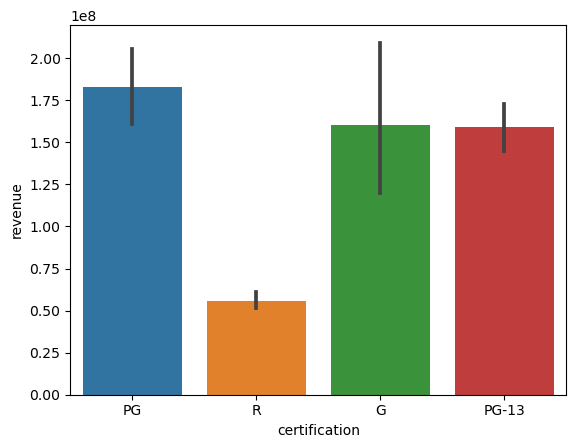

In [109]:
ax = sns.barplot(data=df, x='certification', y='revenue')

### Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

##### Null Hypothesis:  Different MPAA ratings all have the same revenue. (the revenue is not significantly different between ratings)

##### Alternative Hypothesis: Different MPAA ratings have different revenues. (the revenue is significantly different between ratings)

##### Using an alpha=.05

In [117]:
## Create groups dictionary. There are only 4 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['certification'].unique():
    ## Get series for group and rename
    data = df.loc[df['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['PG', 'R', 'G', 'PG-13'])

In [113]:
df['certification'].value_counts()

R        1679
PG-13    1390
PG        510
G          85
Name: certification, dtype: int64

In [85]:
for certification, data in groups.items():
    outliers = np.abs(stats.zscore(data)) > 3
    print(f'There were {outliers.sum()} outliers in the {certification} group.')
    data = data.loc[~outliers]
    groups[certification] = data

There were 14 outliers in the PG group.
There were 42 outliers in the R group.
There were 1 outliers in the G group.
There were 47 outliers in the PG-13 group.
There were 0 outliers in the nan group.
There were 4 outliers in the NR group.
There were 0 outliers in the NC-17 group.


In [118]:
## Running normal test on each group and confirming there are >20 in each group

norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
PG,510.0,4.875788e-59,268.536477
R,1679.0,1.868409e-307,1412.537073
G,85.0,6.339621e-14,60.778744
PG-13,1390.0,2.011197e-259,1191.341618


In [119]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
PG,510.0,4.875788e-59,268.536477,True
R,1679.0,1.868409e-307,1412.537073,True
G,85.0,6.339621e-14,60.778744,True
PG-13,1390.0,2.011197e-259,1191.341618,True


##### There is not normal distribution.

In [122]:
stats.levene(*groups.values())

LeveneResult(statistic=71.09359772557129, pvalue=1.1017313711822157e-44)

##### We did not meet the assumption of equal variance.

In [124]:
# perform the correct hypothesis test
# note again the use of the * operator for convenience
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=90.6244051195013, pvalue=1.440562991550567e-56)

In [125]:
result = stats.kruskal(*groups.values())
print(result)
result.pvalue<0.05

KruskalResult(statistic=423.4669378128522, pvalue=1.8268151137082246e-91)


True

##### I reject the Null Hypothesis and support the alternative hypothesis.

## T-Test for belongs to a collection.

##### Null Hypothesis:  Belongs to a collection and not belong to a collection  all have the same revenue. (the revenue is not significantly different between belonging to a collection and not belonging to a collection)

##### Alternative Hypothesis: Belonging to a collection and not belonging to a collection have different revenues. (the revenue is significantly different between belonging to a collection and not belonging to a collection)

##### Using an alpha=.05

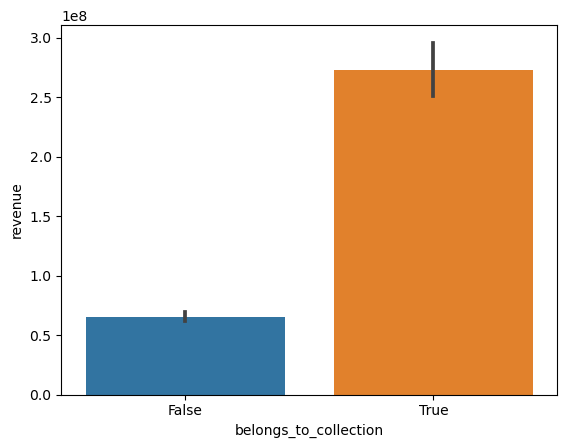

In [127]:
ax = sns.barplot(data=df, x='belongs_to_collection', y='revenue')

In [128]:
df['belongs_to_collection'].value_counts()

False    2786
True      878
Name: belongs_to_collection, dtype: int64

In [129]:
# Filtering out those with and without super strength
belongs_df = df.loc[df['belongs_to_collection']== True].copy()
not_belong_df = df.loc[df['belongs_to_collection']== False].copy()
belongs_revenue = belongs_df['revenue']
not_belongs_revenue = not_belong_df['revenue']

In [130]:
zscores= stats.zscore(belongs_revenue)
outliers = abs(zscores)>3
np.sum(outliers)

13

In [131]:

belongs_revenue = belongs_revenue[(np.abs(stats.zscore(belongs_revenue)) < 3)]

In [132]:
zscores= stats.zscore(not_belongs_revenue)
outliers = abs(zscores)>3
np.sum(outliers)

53

In [133]:

not_belongs_revenue = not_belongs_revenue[(np.abs(stats.zscore(not_belongs_revenue)) < 3)]

In [134]:
result_belongs_revenue = stats.normaltest(belongs_revenue)
result_belongs_revenue

NormaltestResult(statistic=220.0307555866867, pvalue=1.6631388166696075e-48)

In [135]:
result_not_belongs_revenue = stats.normaltest(not_belongs_revenue)
result_not_belongs_revenue

NormaltestResult(statistic=1041.3172822748818, pvalue=7.600203112069189e-227)

##### Data is not normally distributed. 

In [136]:
# Test for equal variance
result = stats.levene(belongs_revenue, not_belongs_revenue)
result

LeveneResult(statistic=920.3092358739823, pvalue=3.4017674657300553e-180)

In [139]:
# Test for equal variance
result = stats.ttest_ind(belongs_revenue, not_belongs_revenue, equal_var = False)
result

Ttest_indResult(statistic=20.195087189824065, pvalue=4.195704832698942e-75)

##### Reject the Null Hypothesis and support Alternative Hypothesis.

## Which year made more revenue.

In [1]:
##### Null Hypothesis:  Each Year has the  all same revenue. (the revenue is not significantly different between years)

##### Alternative Hypothesis: Each year has a different revenue. (the revenue is significantly different between years)

##### Using an alpha=.05

In [140]:
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,release_date,revenue,runtime,title,...,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day
3,tt0118694,0.0,False,150000.0,27.912,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...",2000-09-29,12854953.0,99.0,In the Mood for Love,...,False,False,False,False,False,False,False,2000.0,9.0,29.0
10,tt0120467,0.0,False,120000.0,4.885,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",2002-04-26,14904.0,87.0,Vulgar,...,False,False,False,False,False,False,False,2002.0,4.0,26.0
12,tt0120630,0.0,True,45000000.0,53.584,"[{'id': 521, 'logo_path': '/kP7t6RwGz2AvvTkvnI...",2000-06-23,224834564.0,84.0,Chicken Run,...,False,True,False,False,False,False,False,2000.0,6.0,23.0
15,tt0120753,0.0,False,8000000.0,11.789,"[{'id': 1490, 'logo_path': None, 'name': 'Kint...",2000-02-09,105983.0,122.0,The Million Dollar Hotel,...,False,False,False,False,False,False,False,2000.0,2.0,9.0
16,tt0120755,0.0,True,125000000.0,36.761,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",2000-05-24,546388105.0,123.0,Mission: Impossible II,...,False,False,False,False,False,False,False,2000.0,5.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48377,tt9134216,0.0,False,29900000.0,17.624,"[{'id': 8000, 'logo_path': '/f8NwLg72BByt3eav7...",2019-11-08,69412425.0,96.0,Playing with Fire,...,False,True,False,False,False,False,False,2019.0,11.0,8.0
48513,tt9285882,0.0,False,1600000.0,21.654,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",2019-11-22,5750000.0,91.0,Blue Story,...,False,False,False,False,False,False,False,2019.0,11.0,22.0
48515,tt9288776,0.0,True,11936735.0,32.644,"[{'id': 67089, 'logo_path': '/1wnxolUB5NHZARme...",2019-01-11,61631776.0,99.0,White Snake,...,False,False,False,False,False,False,False,2019.0,1.0,11.0
48568,tt9354944,0.0,False,5000000.0,20.039,"[{'id': 5490, 'logo_path': '/xuJSR4dWsvkE194ae...",2019-10-10,9341824.0,84.0,Jexi,...,False,False,False,False,False,False,False,2019.0,10.0,10.0


In [141]:
df[df['release_date'].isna()]

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,release_date,revenue,runtime,title,...,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day


In [142]:
## drop original feature
df = df.drop(columns=['release_date'])

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3664 entries, 3 to 48630
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                3664 non-null   object 
 1   adult                  3664 non-null   float64
 2   belongs_to_collection  3664 non-null   bool   
 3   budget                 3664 non-null   float64
 4   popularity             3664 non-null   float64
 5   production_companies   3664 non-null   object 
 6   revenue                3664 non-null   float64
 7   runtime                3664 non-null   float64
 8   title                  3664 non-null   object 
 9   vote_average           3664 non-null   float64
 10  vote_count             3664 non-null   float64
 11  certification          3664 non-null   object 
 12  Genre_Comedy           3664 non-null   bool   
 13  Genre_Music            3664 non-null   bool   
 14  Genre_Romance          3664 non-null   bool   
 15  Gen

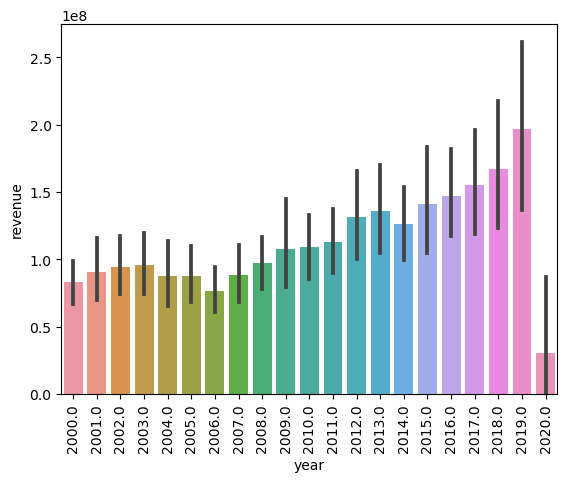

In [147]:
sns.barplot(data=df, x='year',y='revenue');
plt.xticks(rotation='vertical');

In [153]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['year'].unique():
    ## Get series for group and rename
    data = df.loc[df['year']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys([2000.0, 2002.0, 2001.0, 2003.0, 2004.0, 2005.0, 2007.0, 2006.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0])

In [151]:
df.drop(df[df['year'] == 2020].index, inplace = True)
df['year'].value_counts()

2006.0    218
2009.0    217
2014.0    215
2007.0    214
2011.0    212
2008.0    210
2010.0    207
2015.0    191
2012.0    189
2016.0    186
2013.0    183
2005.0    181
2017.0    172
2004.0    166
2002.0    164
2001.0    157
2003.0    154
2018.0    147
2000.0    141
2019.0    136
Name: year, dtype: int64

In [154]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
2000.0,141.0,3.547282e-15,66.545189
2002.0,164.0,4.617887e-31,139.700401
2001.0,157.0,2.178434e-31,141.203064
2003.0,154.0,6.327897e-34,152.885851
2004.0,166.0,2.886717e-32,145.245206
2005.0,181.0,5.181909e-35,157.890609
2007.0,214.0,2.008662e-40,182.811869
2006.0,218.0,2.017017e-47,215.039759
2008.0,210.0,7.626291e-33,147.907413
2009.0,217.0,1.242078e-73,335.743852


In [155]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
2000.0,141.0,3.547282e-15,66.545189,True
2002.0,164.0,4.617887e-31,139.700401,True
2001.0,157.0,2.178434e-31,141.203064,True
2003.0,154.0,6.327897e-34,152.885851,True
2004.0,166.0,2.886717e-32,145.245206,True
2005.0,181.0,5.181909e-35,157.890609,True
2007.0,214.0,2.008662e-40,182.811869,True
2006.0,218.0,2.017017e-47,215.039759,True
2008.0,210.0,7.626291e-33,147.907413,True
2009.0,217.0,1.242078e-73,335.743852,True


In [156]:
stats.levene(*groups.values())

LeveneResult(statistic=4.253624976261585, pvalue=1.7724455019744324e-09)

##### No equal variance

In [157]:
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=3.970488508112641, pvalue=1.4156621272511378e-08)

##### Reject the null hypothesis and support the alternative hypothesis.